# preparing

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import functions
from preprocess_dataframe import get_preprocess_dataframe
import os
import re
import glob
import math
import plotly.graph_objs as go
from shutil import copyfile
import time

## prepare paths

In [2]:
cycle_test=20

In [3]:
times=25

In [4]:
main_path='/media/alena/ext_space/job_analyze'
disabled_path="{}/disabled_folder{}".format(main_path,cycle_test)
frozen_path='{}/frozen_folder{}'.format(main_path,cycle_test)
learn_path='{}/learn_folder{}'.format(main_path,cycle_test)

## prepare func import dataframes

In [5]:
def readcsv(args):
    return pd.read_csv(args, header=None)

def get_df(path_folder,mode,times):
    
    df_ex_pl_time = pd.DataFrame()
    df_ex_pl_time_orig = pd.DataFrame()
    df_explains_plans = pd.DataFrame()
    df_query_err=pd.DataFrame()
    df_query_stat=pd.DataFrame()
    df_query_data=pd.DataFrame()
    filename_basics=glob.glob("{}/*_report.csv".format(path_folder, mode))
    if mode !='disabled':
        filename_others=['{}/{}_aqo_data.csv'.format(path_folder,mode), '{}/{}_aqo_query_stat.csv'.format(path_folder,mode)] 
        dfs = [df_query_data,df_query_err, df_query_stat]
    
    #print(filename_basics)
    for file in filename_basics:
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_list = []
            for file in filename_basics:
                df=pd.read_csv(file)
                df['Query hash'] = df['Query hash'].astype(str)
                df_list.append(df)
            df_ex_pl_time = pd.concat(df_list, ignore_index=True)
        else:
            df_ex_pl_time = df_list[0]
    if mode !='disabled':
        for k,file in enumerate(filename_others):
            dfs[k] = pd.read_csv(file)
    
    #explains
    dict_q={}
    dict_q_text={}
    lst=[]
    q=''
    plan=''
    k=0
    with open('{}/explains.txt'.format(path_folder)) as f:
        for line in f:
            str_=line
            if str_.replace(' ','')=='':
                continue
            if str_.find("QUERY PLAN")==0:
                if q not in list(dict_q.keys()):
                    dict_q[q]=1
                    dict_q_text[q]=[]
                    dict_q_text[q].append(re.sub(r'<b>\((.+)\)</b>', r'<b>\1</b>', str_))
                    #dict_q[q].append(str_)
                else:
                    str_=re.sub(r'<b>\((.+)\)</b>', r'<b>\1</b>', str_)
                    for i in list(dict_q_text[q]):
                        if i==str_:
                            dict_q[q]+=1
                            dict_q_text[q].append(str_)
                            break
                    #dict_q[q].append(str_)
                q=''
            else:
                q+=str_
    
    df_explains_plans = pd.DataFrame(dict_q.items())
    df_explains_plans.columns=['query_string', 'plans']
    #lst=[]
    #for i in df_explains_plans.itertuples(index=False):
    #    lst.append(len(i.plans)>1)
    #df_explains_plans['changed']=lst

    #report
    df_ex_pl_time = df_ex_pl_time.fillna(0)
    print(df_ex_pl_time)
    df_ex_pl_time = df_ex_pl_time.rename(columns = {'Plan time': 'plan_time',
                                         'Query Number':'query_number', 
                                         'Query Name':'query_name', 
                                         'Execution Time':'execution_time', 
                                         'Query hash':'query_hash'})
    df_ex_pl_time['query_number'] = df_ex_pl_time['query_number'].astype(int)
    df_ex_pl_time['query_hash'] = df_ex_pl_time['query_hash'].astype(str)
    df_ex_pl_time['plan_time'] = df_ex_pl_time['plan_time'].astype(float)
    df_ex_pl_time_orig=df_ex_pl_time.copy()
    if times>1:
        lst_data = []
        dict_query = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_name in dict_query:
                dict_query[i.query_name][1] += i.execution_time
                dict_query[i.query_name][3] += i.plan_time
            else:
                dict_query[i.query_name] = [i.query_name, i.execution_time, i.query_hash, i.plan_time]
        df_ex_pl_time = pd.DataFrame(dict_query.values(), columns = ['query_name', 'execution_time', 'query_hash', 'plan_time'])
        df_ex_pl_time['exec_time_avg'] = df_ex_pl_time['execution_time']/times
        df_ex_pl_time['plan_time_avg'] = df_ex_pl_time['plan_time']/times
    
    if mode !='disabled':
        #err
        filename_basics=glob.glob("{}/*_err*.csv".format(path_folder, mode))
        lst=[]
        df_list=[]
        def f(lst,k,l):
            lst_temp=[k]*l
            lst = lst+lst_temp
        #for file in filename_basics:
            #for iteration,file in enumerate(filename_basics):
            #    df_list.append(pd.read_csv(file))
            #    lst_temp=[iteration]*len(df_list)
            #    lst = lst+lst_temp
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_query_err = pd.concat(df_list, ignore_index=True)
        else:
            df_query_err = df_list[0]
        #df_list['iteration']=lst
        #print(df_query_err.columns)
        df_query_err['id'] = df_query_err['id'].astype(str)
        df_query_err['errdelta'] = df_query_err['errdelta'].astype(float)
    
        #stat
        df_query_stat=dfs[1].fillna(0)
        lst_stat_columns = ['execution_time_with_aqo', 'execution_time_without_aqo',
           'planning_time_with_aqo', 'planning_time_without_aqo',
           'cardinality_error_with_aqo', 'cardinality_error_without_aqo']
        lst_stat_cut = [1, 1, 1, 1, 1, 1]
        df_query_stat = get_preprocess_dataframe(df_query_stat, lst_stat_columns, lst_stat_cut)
        lst_min_val_with_aqo = []
        lst_min_iter_with_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.cardinality_error_with_aqo_split):
                if val < 0.1:
                    if min_val>val:
                        min_val = val
                        iteration = k
                    break
            lst_min_val_with_aqo.append(min_val)
            lst_min_iter_with_aqo.append(iteration)
        df_query_stat['min_iter_card_with'] = lst_min_iter_with_aqo
        df_query_stat['lst_min_val_with_aqo'] = lst_min_val_with_aqo
        

        lst_min_val_without_aqo = []
        lst_min_iter_without_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.cardinality_error_without_aqo_split):
                if min_val > val:
                    min_val = val
                    iteration = k
            lst_min_val_without_aqo.append(min_val)
            lst_min_iter_without_aqo.append(iteration)
        df_query_stat['min_iter_card_without'] = lst_min_iter_without_aqo
        df_query_stat['lst_min_val_without_aqo'] = lst_min_val_without_aqo

        lst_min_val_with_aqo = []
        lst_min_iter_with_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.execution_time_with_aqo_split):
                if min_val>val:
                    min_val = val
                    iteration = k
            lst_min_val_with_aqo.append(min_val)
            lst_min_iter_with_aqo.append(iteration)
        df_query_stat['min_iter_exec_with'] = lst_min_iter_with_aqo
        df_query_stat['lst_min_exec_with_aqo'] = lst_min_val_with_aqo

        lst_columns = ['cardinality_error_without_aqo_split', 'cardinality_error_with_aqo_split']
        lst_columns_with = ['planning_time_with_aqo_split', 'execution_time_with_aqo_split']
        lst_columns_without = ['planning_time_without_aqo_split', 'execution_time_without_aqo_split']
        for i,j,k in zip(lst_columns, lst_columns_with, lst_columns_without):
            df_query_stat = functions.last_errors(df_query_stat, i, '{}_last_value'.format(i))
            df_query_stat = functions.last_errors(df_query_stat, j,'{}_last_value'.format(i))
            df_query_stat = functions.last_errors(df_query_stat, k,'{}_last_value'.format(i))
        
        dict_hash = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_hash in dict_hash:
                dict_hash[str(i.query_hash)].append(i.query_name)
            else:
                dict_hash[i.query_hash] = []
                dict_hash[str(i.query_hash)].append(i.query_name)
        df_temp=pd.DataFrame(dict_hash.items())
        df_temp.columns=['queryid', 'query_name']
        df_temp['queryid'] = df_temp['queryid'].astype(str)
        df_query_stat['queryid'] = df_query_stat['queryid'].astype(str)
        #print(df_query_stat.columns)
        df_query_stat=df_query_stat.merge(df_temp, how='left', on='queryid')
        df_query_err=df_query_err.merge(df_temp,left_on='id', right_on='queryid')
        df_query_err['query_name'] = df_query_err['query_name'].astype(str)
        df_query_stat['query_name'] = df_query_stat['query_name'].astype(str)
        df_query_err=df_query_err.drop(columns=['queryid'])
    
    if mode !='disabled':
        return df_explains_plans, df_ex_pl_time, df_ex_pl_time_orig, df_query_err, df_query_stat
    else:
        return df_explains_plans, df_ex_pl_time

In [6]:
learn_df_explains_plans, learn_df_ex_pl_time, learn_df_ex_pl_time_orig, learn_df_query_err, learn_df_query_stat=get_df(learn_path,'learn',times)

      Query Number Query Name  Execution Time  Plan time            Query hash
0               16    10a.sql         206.335     28.501  -6651533820180303979
1               16    10b.sql         112.242     29.774    988535410010893112
2               16    10c.sql        8556.694     29.859   2494719406442254794
3               16    11a.sql          48.884     56.117  -8754961486292191806
4               16    11b.sql          35.086     54.896   7102013096890644952
...            ...        ...             ...        ...                   ...
2707            23     8d.sql        2526.363     27.989  -2444720784039749802
2708            23     9a.sql        1316.495     70.253  -6747521538659772949
2709            23     9b.sql        1564.346     62.008    316739818532851506
2710            23     9c.sql        1464.301     68.319   -180252288200201541
2711            23     9d.sql        8755.831     59.276   7221379846823333251

[2712 rows x 5 columns]


/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [7]:
disabled_df_explains_plans, disabled_df_ex_pl_time=get_df(disabled_path,'disabled',1)

     Query Number Query Name  Execution Time  Plan time           Query hash
0               1    10a.sql        3628.991     31.120 -6651533820180303979
1               1    10b.sql         136.294     15.685   988535410010893112
2               1    10c.sql       13919.205     12.594  2494719406442254794
3               1    11a.sql          98.600     32.951 -8754961486292191806
4               1    11b.sql          25.708     23.890  7102013096890644952
..            ...        ...             ...        ...                  ...
108             1     8d.sql        3921.632     18.044 -2444720784039749802
109             1     9a.sql        3713.662     27.590 -6747521538659772949
110             1     9b.sql        1450.252     31.175   316739818532851506
111             1     9c.sql        1456.765     28.700  -180252288200201541
112             1     9d.sql       13066.588     27.772  7221379846823333251

[113 rows x 5 columns]


In [8]:
frozen_df_explains_plans, frozen_df_ex_pl_time, frozen_df_ex_pl_time_orig, frozen_df_query_err, frozen_df_query_stat=get_df(frozen_path,'frozen',1)

     Query Number Query Name  Execution Time  Plan time           Query hash
0               1    10a.sql         205.633     31.028 -6651533820180303979
1               1    10b.sql         110.300     29.188   988535410010893112
2               1    10c.sql        8573.169     28.824  2494719406442254794
3               1    11a.sql          48.232     53.624 -8754961486292191806
4               1    11b.sql          25.329     53.186  7102013096890644952
..            ...        ...             ...        ...                  ...
108             1     8d.sql        2405.264     25.450 -2444720784039749802
109             1     9a.sql        1479.189     64.955 -6747521538659772949
110             1     9b.sql        1458.797     61.177   316739818532851506
111             1     9c.sql        1518.328     60.957  -180252288200201541
112             1     9d.sql        9091.670     53.950  7221379846823333251

[113 rows x 5 columns]


/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [9]:
frozen_df_ex_pl_time

query_number query_name  execution_time  plan_time            query_hash
0               1    10a.sql         205.633     31.028  -6651533820180303979
1               1    10b.sql         110.300     29.188    988535410010893112
2               1    10c.sql        8573.169     28.824   2494719406442254794
3               1    11a.sql          48.232     53.624  -8754961486292191806
4               1    11b.sql          25.329     53.186   7102013096890644952
..            ...        ...             ...        ...                   ...
108             1     8d.sql        2405.264     25.450  -2444720784039749802
109             1     9a.sql        1479.189     64.955  -6747521538659772949
110             1     9b.sql        1458.797     61.177    316739818532851506
111             1     9c.sql        1518.328     60.957   -180252288200201541
112             1     9d.sql        9091.670     53.950   7221379846823333251

[113 rows x 5 columns]

In [10]:
frozen_df_ex_pl_time[frozen_df_ex_pl_time['query_name']=='32a.sql']

query_number query_name  execution_time  plan_time           query_hash
82             1    32a.sql          19.976      29.39  6225652705960457954

## Main report analyze

In [11]:
frozen_df_ex_pl_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   query_number    113 non-null    int64  
 1   query_name      113 non-null    object 
 2   execution_time  113 non-null    float64
 3   plan_time       113 non-null    float64
 4   query_hash      113 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 4.5+ KB


In [12]:
# frozen_df_ex_pl_time, frozen_df_ex_pl_time, frozen_df_query_err, frozen_df_query_stat

In [13]:
def renames(df, mode):
    df = df.rename(columns = {'plan_time':'plan_time_{}'.format(mode), 'execution_time':'execution_time_{}'.format(mode)})
    if mode == 'control' or mode == 'disabled':
        df = df.rename(columns = {'plan_time_avg':'plan_time_avg_{}'.format(mode), 'exec_time_avg':'exec_time_avg_{}'.format(mode)})
    return df

In [14]:
frozen_df_ex_pl_time=renames(frozen_df_ex_pl_time,'frozen')


In [15]:
disabled_df_ex_pl_time=renames(disabled_df_ex_pl_time,'disabled')

In [16]:
learn_df_ex_pl_time=renames(learn_df_ex_pl_time,'learn')

In [17]:
disabled_df_ex_pl_time

query_number query_name  execution_time_disabled  plan_time_disabled  \
0               1    10a.sql                 3628.991              31.120   
1               1    10b.sql                  136.294              15.685   
2               1    10c.sql                13919.205              12.594   
3               1    11a.sql                   98.600              32.951   
4               1    11b.sql                   25.708              23.890   
..            ...        ...                      ...                 ...   
108             1     8d.sql                 3921.632              18.044   
109             1     9a.sql                 3713.662              27.590   
110             1     9b.sql                 1450.252              31.175   
111             1     9c.sql                 1456.765              28.700   
112             1     9d.sql                13066.588              27.772   

               query_hash  
0    -6651533820180303979  
1      988535410010893112  
2     2494719406442254794  
3    -8754961486292191806  
4     7102013096890644952  
..                    ...  
108  -2444720784039749802  
109  -6747521538659772949  
110    316739818532851506  
111   -180252288200201541  
112   7221379846823333251  

[113 rows x 5 columns]

In [18]:
df_ex_pl_time = frozen_df_ex_pl_time.merge(disabled_df_ex_pl_time, how='left', on=['query_name','query_number','query_hash'])

In [19]:
#df = df.merge(learn_df_ex_pl_time, how='left', on=['query_name','query_hash'])

In [20]:
df_ex_pl_time

query_number query_name  execution_time_frozen  plan_time_frozen  \
0               1    10a.sql                205.633            31.028   
1               1    10b.sql                110.300            29.188   
2               1    10c.sql               8573.169            28.824   
3               1    11a.sql                 48.232            53.624   
4               1    11b.sql                 25.329            53.186   
..            ...        ...                    ...               ...   
108             1     8d.sql               2405.264            25.450   
109             1     9a.sql               1479.189            64.955   
110             1     9b.sql               1458.797            61.177   
111             1     9c.sql               1518.328            60.957   
112             1     9d.sql               9091.670            53.950   

               query_hash  execution_time_disabled  plan_time_disabled  
0    -6651533820180303979                 3628.991              31.120  
1      988535410010893112                  136.294              15.685  
2     2494719406442254794                13919.205              12.594  
3    -8754961486292191806                   98.600              32.951  
4     7102013096890644952                   25.708              23.890  
..                    ...                      ...                 ...  
108  -2444720784039749802                 3921.632              18.044  
109  -6747521538659772949                 3713.662              27.590  
110    316739818532851506                 1450.252              31.175  
111   -180252288200201541                 1456.765              28.700  
112   7221379846823333251                13066.588              27.772  

[113 rows x 7 columns]

In [21]:
learn_df_ex_pl_time_orig

query_number query_name  execution_time  plan_time            query_hash
0               16    10a.sql         206.335     28.501  -6651533820180303979
1               16    10b.sql         112.242     29.774    988535410010893112
2               16    10c.sql        8556.694     29.859   2494719406442254794
3               16    11a.sql          48.884     56.117  -8754961486292191806
4               16    11b.sql          35.086     54.896   7102013096890644952
...            ...        ...             ...        ...                   ...
2707            23     8d.sql        2526.363     27.989  -2444720784039749802
2708            23     9a.sql        1316.495     70.253  -6747521538659772949
2709            23     9b.sql        1564.346     62.008    316739818532851506
2710            23     9c.sql        1464.301     68.319   -180252288200201541
2711            23     9d.sql        8755.831     59.276   7221379846823333251

[2712 rows x 5 columns]

## err_data

In [22]:
frozen_df_query_err

id  errdelta   query_name
0   -9026514954839072455  1.628774  ['12a.sql']
1   -8754961486292191806  1.091811  ['11a.sql']
2   -7994933085961275538  1.143422  ['23b.sql']
3   -7971004576533452411  2.250916  ['21c.sql']
4   -7678011977838348522  1.653862   ['7c.sql']
..                   ...       ...          ...
90   7519382914444524780  3.220086  ['31a.sql']
91   7721649514993682563  1.654618  ['30b.sql']
92   7915967579038312663  1.775530  ['19d.sql']
93   9105500078934324812  3.255533  ['25c.sql']
94   9106003620751043838  2.005997   ['5a.sql']

[95 rows x 3 columns]

In [23]:
def renames(df, mode, column):
    df = df.rename(columns = {column:'{}_{}'.format(column,mode)})
    return df

In [24]:
learn_df_query_err=renames(learn_df_query_err,'learn','errdelta')

In [25]:
frozen_df_query_err=renames(frozen_df_query_err,'frozen','errdelta')

In [26]:
df_err = learn_df_query_err.merge(frozen_df_query_err, how='left', on=['id', 'query_name'])

In [27]:
df_err

id  errdelta_learn                      query_name  \
0       988535410010893112        0.000000                     ['10b.sql']   
1       988535410010893112        0.000000                     ['10b.sql']   
2       988535410010893112        0.000000                     ['10b.sql']   
3       988535410010893112        0.000000                     ['10b.sql']   
4       988535410010893112        0.000000                     ['10b.sql']   
...                    ...             ...                             ...   
2370  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
2371  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
2372  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
2373  -1950505845315524548        0.972896  ['4a.sql', '4b.sql', '4c.sql']   
2374  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   

      errdelta_frozen  
0            1.174097  
1            1.174097  
2            1.174097  
3            1.174097  
4            1.174097  
...               ...  
2370         1.058083  
2371         1.058083  
2372         1.058083  
2373         1.058083  
2374         1.058083  

[2375 rows x 4 columns]

## learn_df_query_stat

In [28]:
learn_df_query_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   queryid                                         95 non-null     object 
 1   cardinality_error_without_aqo_split             95 non-null     object 
 2   cardinality_error_with_aqo_split                95 non-null     object 
 3   planning_time_without_aqo_split                 95 non-null     object 
 4   planning_time_with_aqo_split                    95 non-null     object 
 5   execution_time_without_aqo_split                95 non-null     object 
 6   execution_time_with_aqo_split                   95 non-null     object 
 7   executions_with_aqo                             95 non-null     int64  
 8   executions_without_aqo                          95 non-null     int64  
 9   min_iter_card_with                           

In [29]:
learn_df_query_stat

queryid                cardinality_error_without_aqo_split  \
0     988535410010893112                               [1.1740974144188687]   
1   -6651533820180303979                               [0.7143779554642938]   
2   -3414057395363075461                               [0.9535934648818055]   
3    3350265702090035455                               [3.3363183637430436]   
4    -917204397272063480                               [3.2684367899399627]   
..                   ...                                                ...   
90  -6885312641126422993                                [2.435159900985331]   
91  -1889760809355916724                                [3.422698326281815]   
92  -6571914703387389993                               [0.8192030121145609]   
93   -460740518707800565                               [0.9069711439578045]   
94  -1950505845315524548  [0.9797096177822553, 0.43957725078436244, 1.06...   

                     cardinality_error_with_aqo_split  \
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3   [0.0027783966906946844, 0.002778356698592314, ...   
4   [0.07946027465286959, 0.07617004131003072, 0.0...   
..                                                ...   
90  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
91  [2.3170095303294103, 1.7735356059843947, 1.578...   
92  [0.0036089565574195276, 0.0036089565574195276,...   
93  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
94  [0.011538125913381528, 0.025015150933378454, 0...   

           planning_time_without_aqo_split  \
0                            [0.015594016]   
1                            [0.031032528]   
2                            [0.008931802]   
3                            [0.029298975]   
4                            [0.020102643]   
..                                     ...   
90                           [0.008036279]   
91                           [0.230780345]   
92                           [0.327569353]   
93                           [0.071101805]   
94  [0.007921086, 0.013954692, 0.00773228]   

                         planning_time_with_aqo_split  \
0   [0.028194271, 0.028352469, 0.026671981, 0.0272...   
1   [0.032363881, 0.038153207, 0.035983498, 0.0328...   
2   [0.014672508, 0.016144518, 0.017432597, 0.0165...   
3   [0.045948472, 0.061029942, 0.049650957, 0.0546...   
4   [0.029668493, 0.058551171, 0.029595127, 0.0303...   
..                                                ...   
90  [0.013026643, 0.013024404, 0.013092918, 0.0133...   
91  [2.812807605, 2.88661867, 2.890404912, 2.87908...   
92  [5.206520992, 5.189403478, 5.458860355, 5.5828...   
93  [0.122834183, 0.124250366, 0.110406894, 0.1139...   
94  [0.019904007, 0.013325445, 0.015236774, 0.0152...   

           execution_time_without_aqo_split  \
0                             [0.137276899]   
1                             [3.631126704]   
2                              [0.17511529]   
3                             [53.85370501]   
4                            [35.944772112]   
..                                      ...   
90                            [0.111605584]   
91                            [2.974395668]   
92                            [0.028497469]   
93                            [0.749720758]   
94  [0.206537737, 0.126354247, 0.210021306]   

                        execution_time_with_aqo_split  executions_with_aqo  \
0   [0.114912928, 0.104817202, 0.100696333, 0.1036...                   24   
1   [0.226364218, 0.187767918, 0.188764619, 0.1791...                   24   
2   [0.171582227, 0.172788406, 0.173456698, 0.1785...                   24   
3   [11.031478584, 10.565212299, 10.320725787, 10....                   24   
4   [14.256029774, 13.434793004, 13.498554946, 13....                   24   
..                                                ...                  ...   
90  [0.104416071, 0.100867644, 0.1

# build graphs: learning

In [30]:
def upload_pics(contain, dir_to, filename):
    plotly.offline.plot(contain, image_filename=filename, image='svg')
    time.sleep(10)
    #os.replace('{}/{}.svg'.format('/home/alena/Downloads', filename), '{}/{}.svg'.format(dir_to, filename))

## err for every query

### err_data

In [31]:
learn_df_query_err

id  errdelta_learn                      query_name
0       988535410010893112        0.000000                     ['10b.sql']
1       988535410010893112        0.000000                     ['10b.sql']
2       988535410010893112        0.000000                     ['10b.sql']
3       988535410010893112        0.000000                     ['10b.sql']
4       988535410010893112        0.000000                     ['10b.sql']
...                    ...             ...                             ...
2370  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
2371  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
2372  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
2373  -1950505845315524548        0.972896  ['4a.sql', '4b.sql', '4c.sql']
2374  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']

[2375 rows x 3 columns]

In [32]:
lst_queries=learn_df_query_err['id'].unique()

In [33]:
lst=[]
for k in range(times):
    lst += [k]*len(lst_queries)
    if len(lst)==len(learn_df_query_err):
        break

In [34]:
len(lst), len(learn_df_query_err)

(2375, 2375)

In [35]:
learn_df_query_err['iter']=lst

In [36]:
name_query = list(learn_df_query_err['query_name'].unique())

In [37]:
from plotly.subplots import make_subplots

In [38]:
ox=list(x for x in range(times))

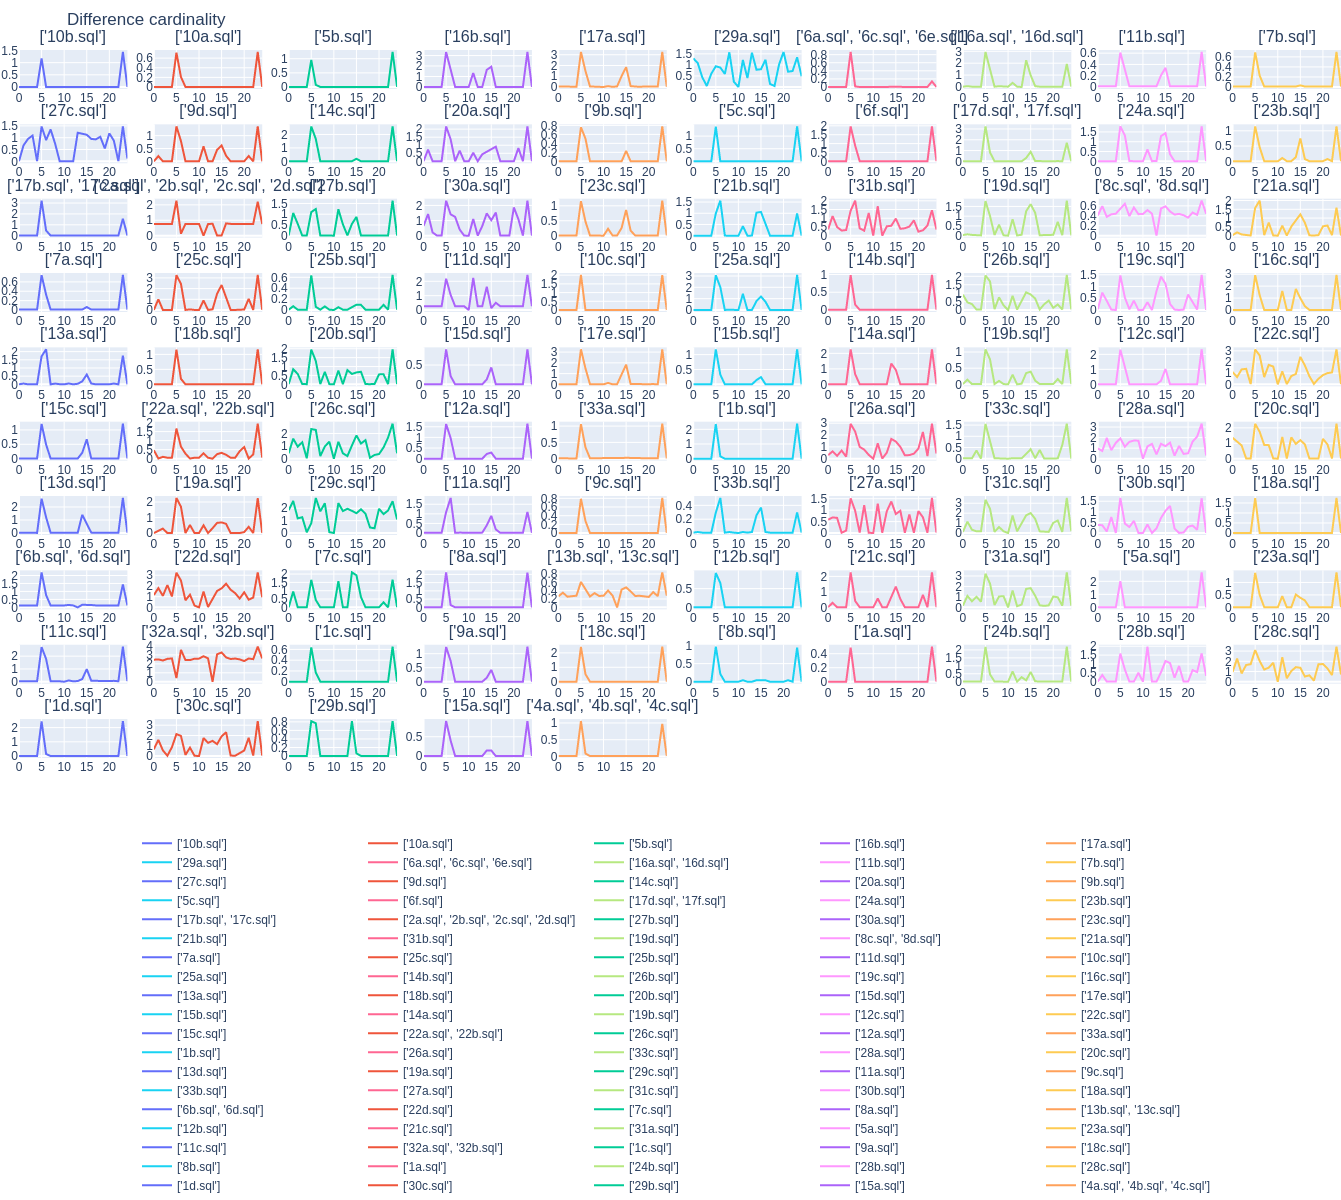

In [39]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_err[learn_df_query_err['query_name']==i]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['errdelta_learn']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                   title_text="Difference cardinality",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Difference cardinality')
fig.show()

### query_stats

In [40]:
name_query=list(learn_df_query_stat['query_name'])

In [41]:
df_temp=learn_df_query_stat[learn_df_query_stat['query_name']=="['15a.sql']"]

In [42]:
oy=df_temp['cardinality_error_with_aqo_split'].to_list()

In [43]:
ox=list(x for x in range(len(df_temp['cardinality_error_with_aqo_split'].to_list()[0])))

In [44]:
ox

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [45]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['cardinality_error_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['cardinality_error_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(title_text="Error cardinality for learn by aqo_query_stat",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Error cardinality for learn by aqo_query_stat')
#fig.show()

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[956165:956165:0329/073420.220371:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


## execution for every query

### learn_df_ex_pl_time_orig

In [46]:
name_query = list(learn_df_query_err['query_name'].unique())

In [47]:
ox=list(x for x in range(times))

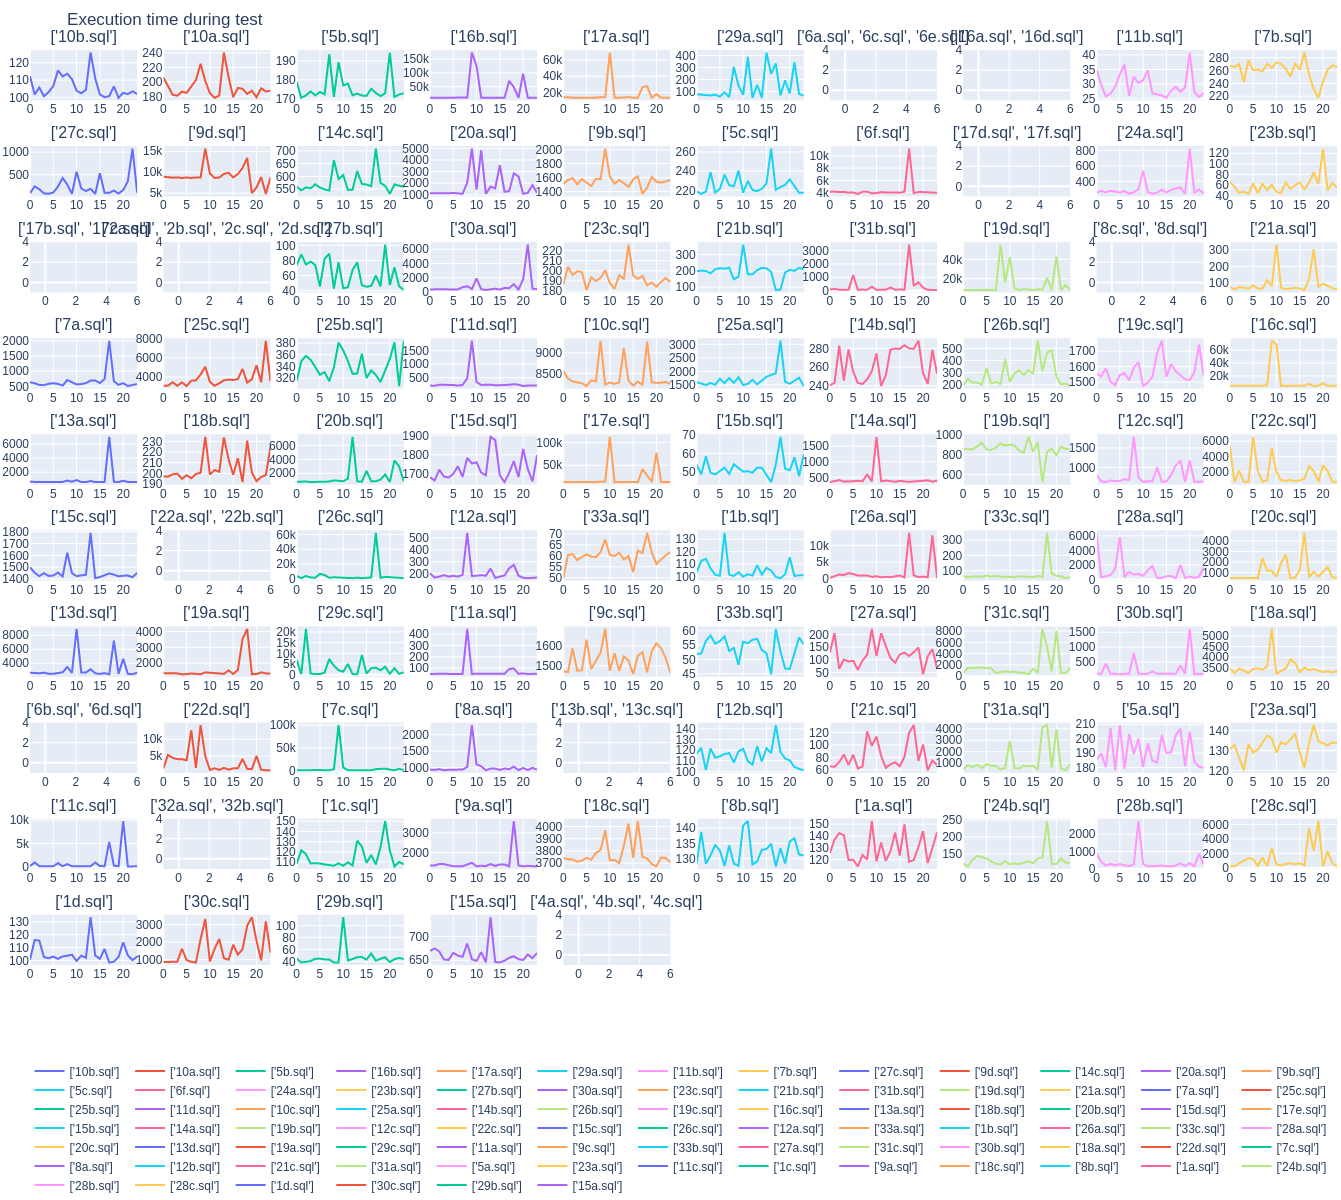

In [48]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_ex_pl_time_orig[learn_df_ex_pl_time_orig['query_name']==i[2:-2]]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['execution_time']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  title_text="Execution time during test",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Execution time during test')
fig.show()

### learn_df_query_stat

In [49]:
name_query=list(learn_df_query_stat['query_name'])

In [50]:
df_temp=learn_df_query_stat[learn_df_query_stat['query_name']=="['15a.sql']"]

In [51]:
ox=list(x for x in range(len(df_temp['execution_time_with_aqo_split'].to_list()[0])))

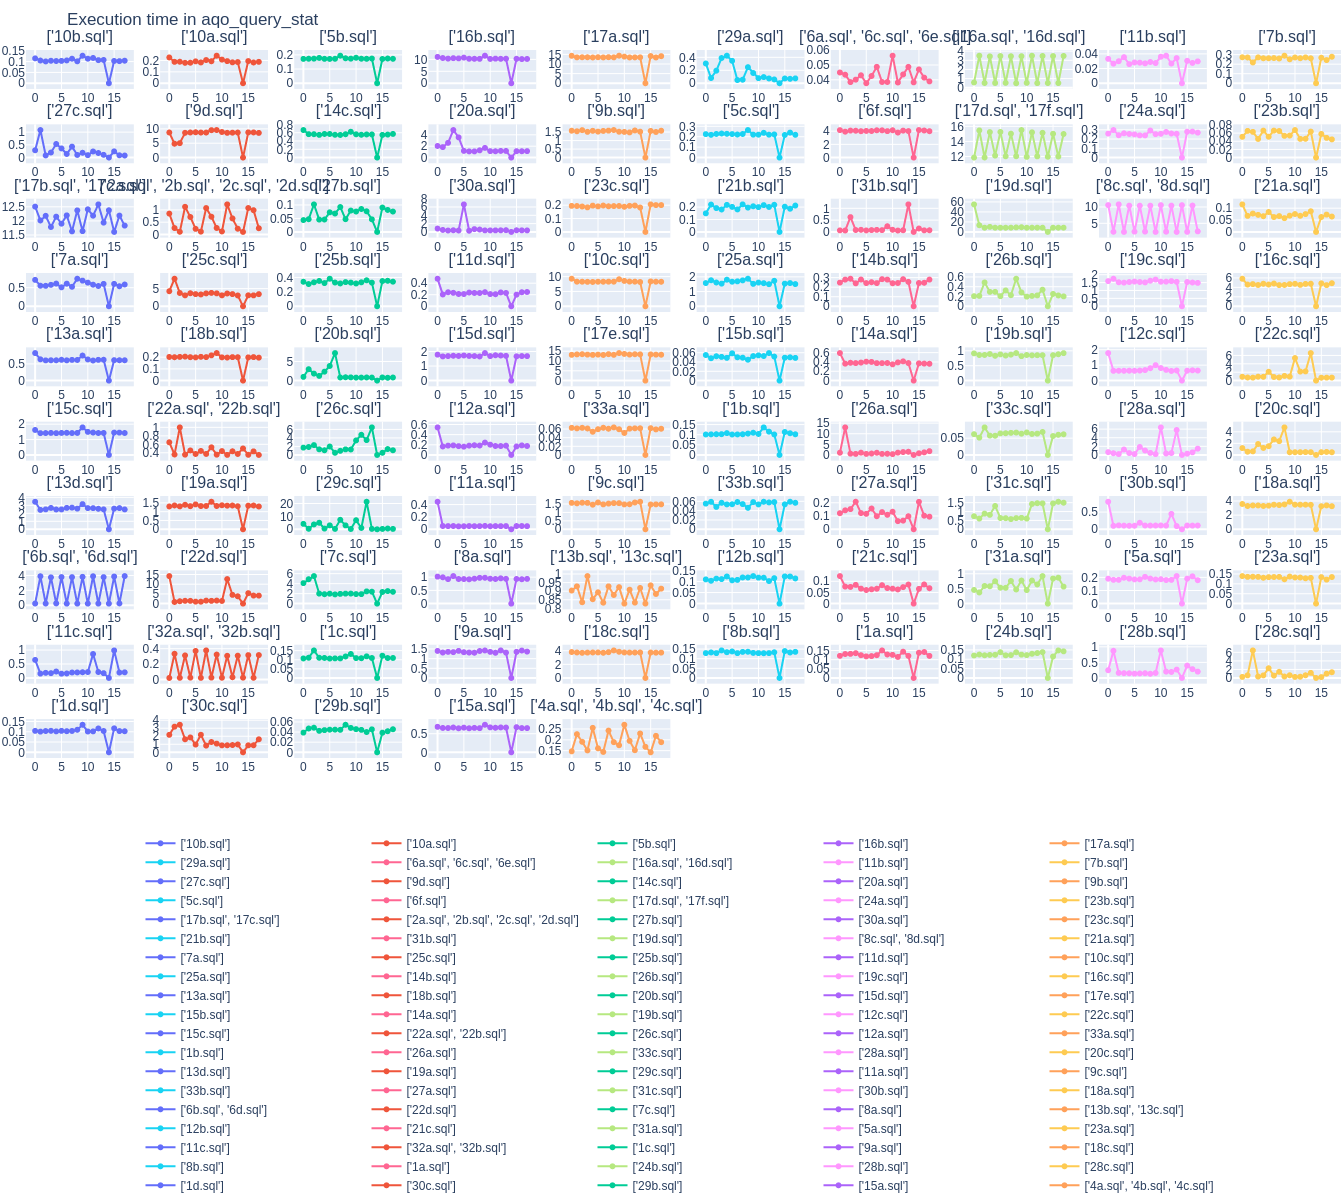

In [52]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['execution_time_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['execution_time_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  title_text="Execution time in aqo_query_stat",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Execution time in aqo_query_stat')
fig.show()

## plan for every query

### learn_df_ex_pl_time_orig

In [53]:
name_query = list(learn_df_query_err['query_name'].unique())

In [54]:
ox=list(x for x in range(times))

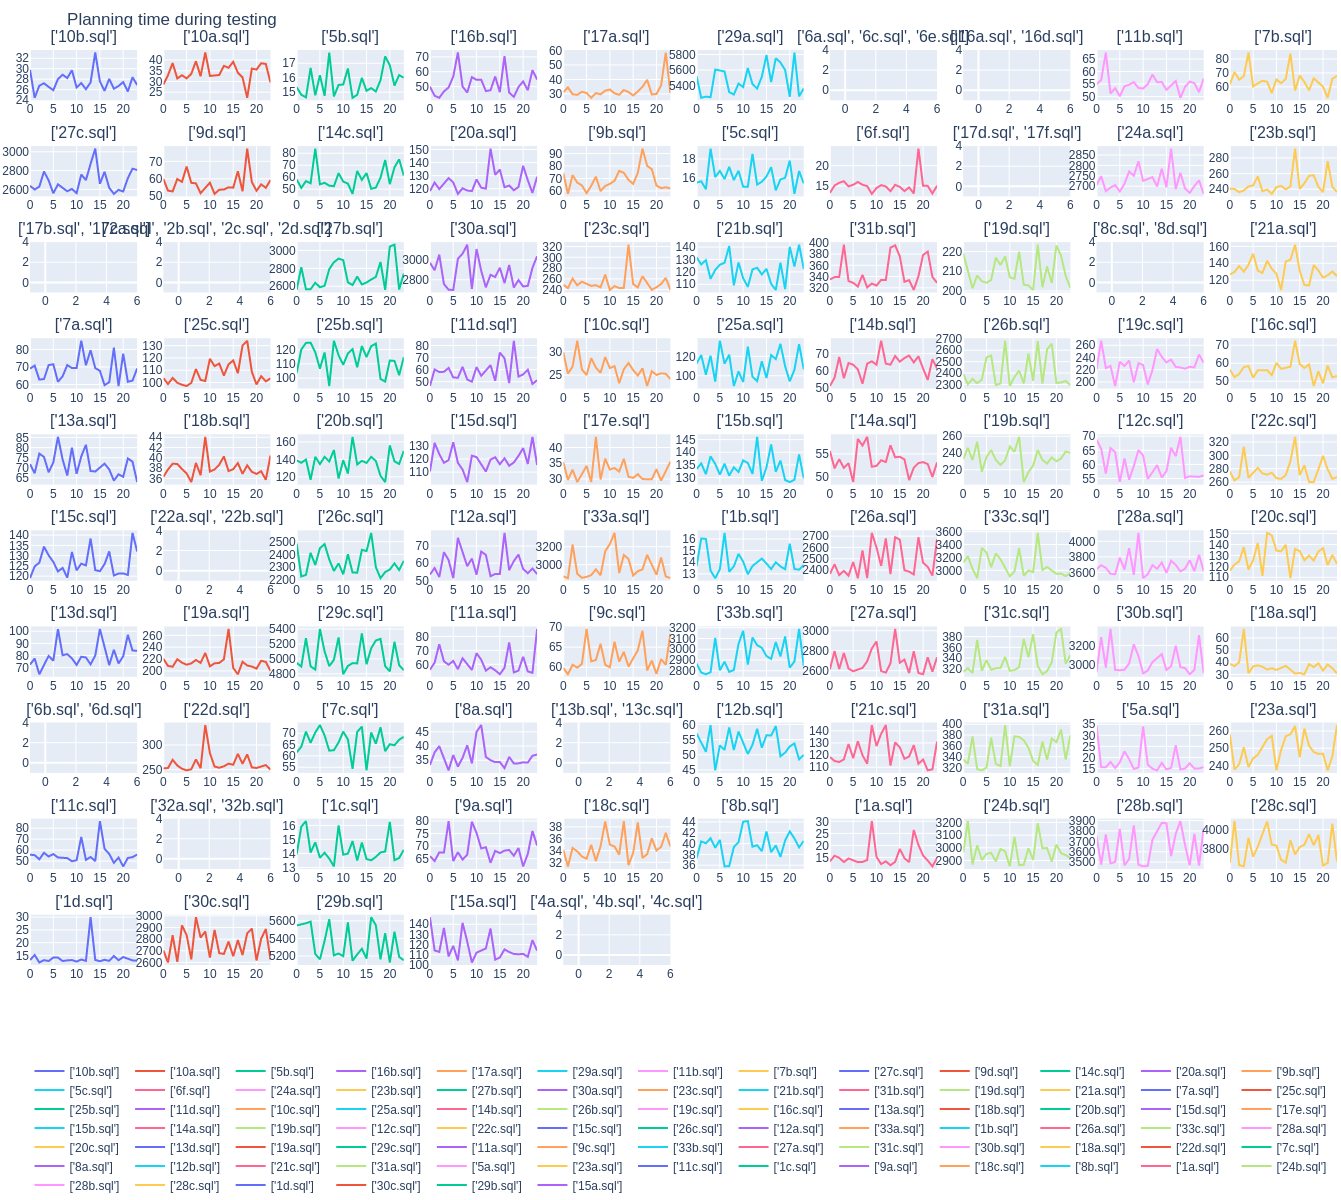

In [55]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_ex_pl_time_orig[learn_df_ex_pl_time_orig['query_name']==i[2:-2]]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['plan_time']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  title='Planning time during testing',
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time during testing')
fig.show()

### aqo_query_stat

In [56]:
name_query=list(learn_df_query_stat['query_name'])

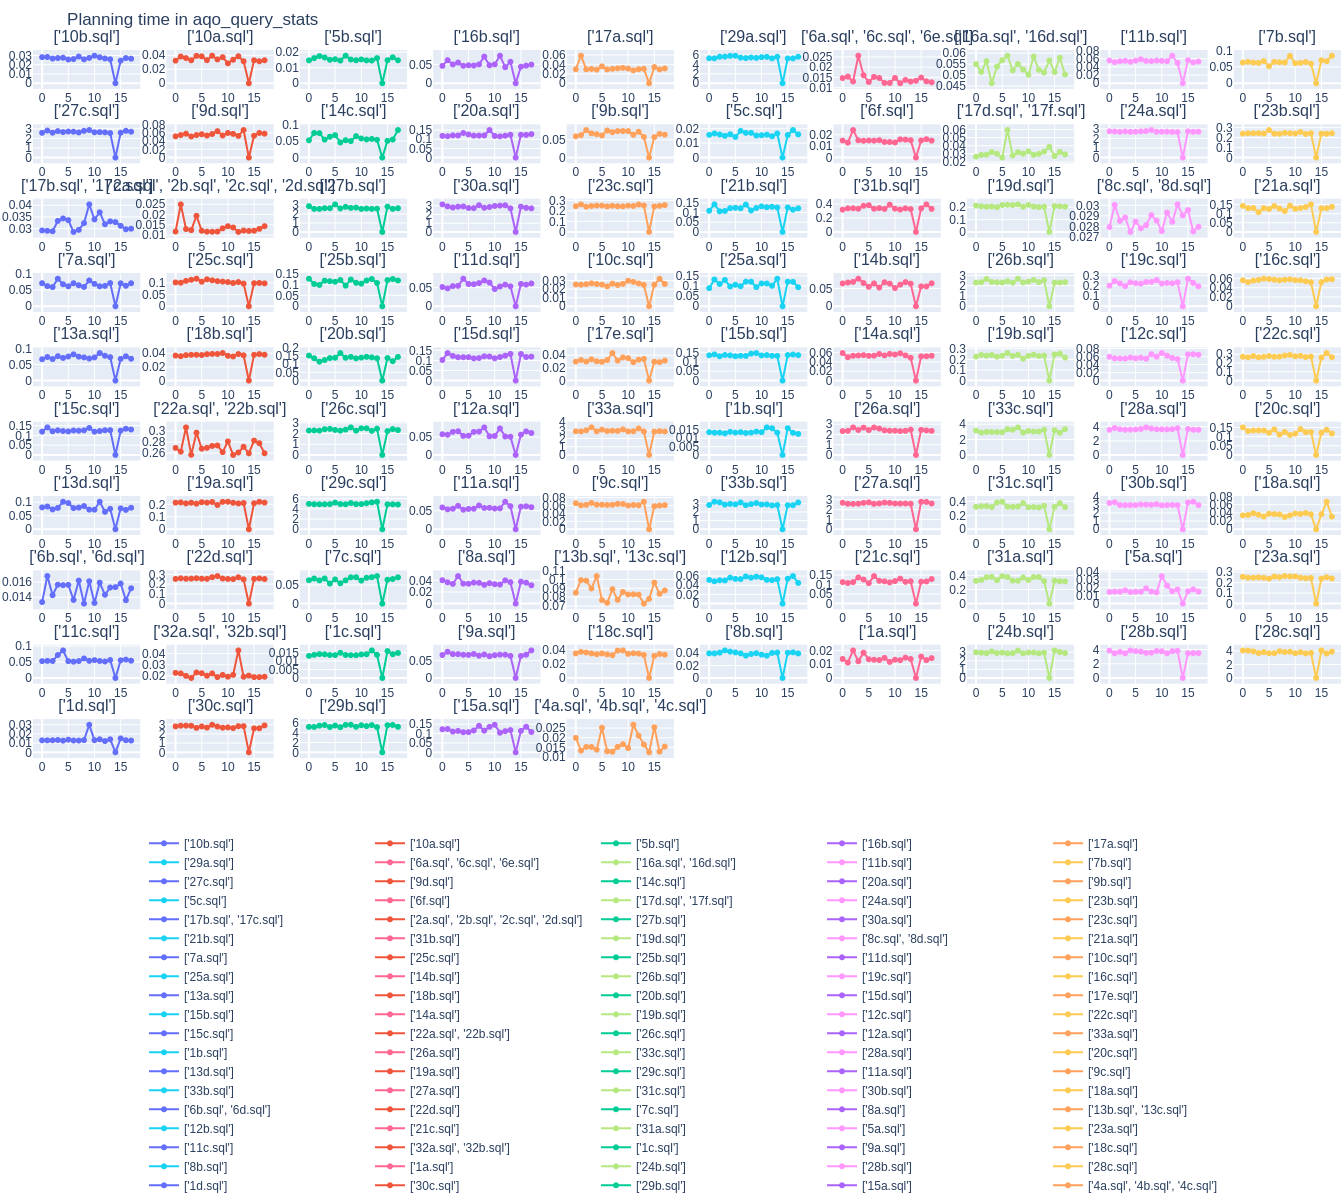

In [57]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['planning_time_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['planning_time_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title='Planning time in aqo_query_stats',
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time during testing')
fig.show()

# build graphs: disabled and control

## query with plan and execution time

### df_ex_pl_time

In [58]:
df_ex_pl_time_copy=df_ex_pl_time.copy()

In [59]:
df_ex_pl_time_copy

query_number query_name  execution_time_frozen  plan_time_frozen  \
0               1    10a.sql                205.633            31.028   
1               1    10b.sql                110.300            29.188   
2               1    10c.sql               8573.169            28.824   
3               1    11a.sql                 48.232            53.624   
4               1    11b.sql                 25.329            53.186   
..            ...        ...                    ...               ...   
108             1     8d.sql               2405.264            25.450   
109             1     9a.sql               1479.189            64.955   
110             1     9b.sql               1458.797            61.177   
111             1     9c.sql               1518.328            60.957   
112             1     9d.sql               9091.670            53.950   

               query_hash  execution_time_disabled  plan_time_disabled  
0    -6651533820180303979                 3628.991              31.120  
1      988535410010893112                  136.294              15.685  
2     2494719406442254794                13919.205              12.594  
3    -8754961486292191806                   98.600              32.951  
4     7102013096890644952                   25.708              23.890  
..                    ...                      ...                 ...  
108  -2444720784039749802                 3921.632              18.044  
109  -6747521538659772949                 3713.662              27.590  
110    316739818532851506                 1450.252              31.175  
111   -180252288200201541                 1456.765              28.700  
112   7221379846823333251                13066.588              27.772  

[113 rows x 7 columns]

In [60]:
df_ex_pl_time_copy['diff_exec_time']=df_ex_pl_time_copy['execution_time_disabled']-df_ex_pl_time_copy['execution_time_frozen']

In [61]:
df_ex_pl_time_copy['rate_exec_time']=df_ex_pl_time_copy['execution_time_disabled']/df_ex_pl_time_copy['execution_time_frozen']

In [62]:
df_ex_pl_time_copy['diff_plan_time']=df_ex_pl_time_copy['plan_time_disabled']-df_ex_pl_time_copy['plan_time_frozen']

In [63]:
df_ex_pl_time_copy['rate_plan_time']=df_ex_pl_time_copy['plan_time_disabled']/df_ex_pl_time_copy['plan_time_frozen']

In [64]:
exec_rate_2x=df_ex_pl_time_copy[df_ex_pl_time_copy['rate_exec_time']>=2]
plan_rate_2x=df_ex_pl_time_copy[df_ex_pl_time_copy['rate_plan_time']>=2]

In [65]:
exec_rate_1x=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<2) & (df_ex_pl_time_copy['rate_exec_time']>=1)]
plan_rate_1x=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<2) & (df_ex_pl_time_copy['rate_plan_time']>=1)]

In [66]:
exec_rate_more_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<1) & (df_ex_pl_time_copy['rate_exec_time']>=0)]
plan_rate_more_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<1) & (df_ex_pl_time_copy['rate_plan_time']>=0)]

In [67]:
exec_rate_less_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<0)]
plan_rate_less_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<0)]

In [68]:
lst_exec=[len(exec_rate_2x), len(exec_rate_1x), len(exec_rate_more_0)]
lst_plan=[len(plan_rate_2x), len(plan_rate_1x), len(plan_rate_more_0)]

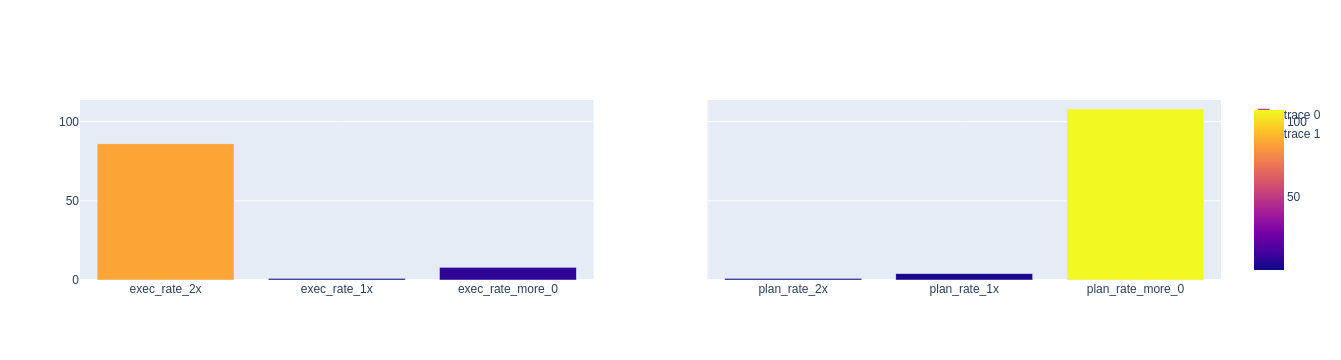

In [106]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Bar(x=['exec_rate_2x', 'exec_rate_1x', 'exec_rate_more_0'], y=lst_exec,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=['plan_rate_2x', 'plan_rate_1x', 'plan_rate_more_0'], y=lst_plan,
                    marker=dict(color=lst_plan, coloraxis="coloraxis")),
              1, 2)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'execution time effective')
fig.show()

In [70]:
df_filter=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']+df_ex_pl_time_copy['rate_plan_time'])>=1]

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[956466:956466:0329/073445.735578:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


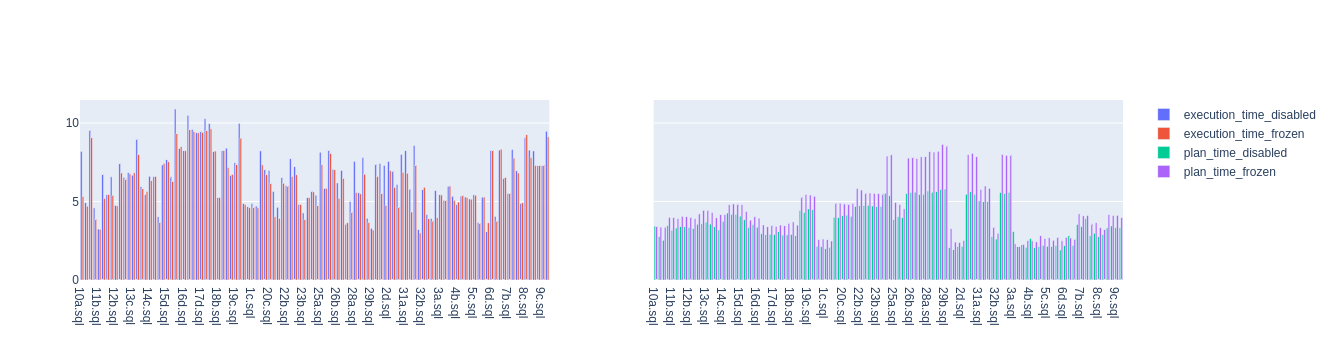

In [71]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Bar(name='execution_time_disabled', x=df_filter['query_name'], y=np.log(df_filter['execution_time_disabled'])),
              1, 1)
fig.add_trace(go.Bar(name='execution_time_frozen',x=df_filter['query_name'], y=np.log(df_filter['execution_time_frozen'])),
              1, 1)
fig.add_trace(go.Bar(name='plan_time_disabled',x=df_filter['query_name'], y=np.log(df_filter['plan_time_disabled'])),
              1, 2)
fig.add_trace(go.Bar(name='plan_time_frozen',x=df_filter['query_name'], y=np.log(df_filter['plan_time_frozen'])),
              1, 2)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time and execution time difference')
fig.show()

### aqo_query_stat

In [72]:
frozen_df_query_stat_copy=frozen_df_query_stat.copy()

In [73]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name'],
      dtype='object')

In [74]:
execution_without=[]
for i in frozen_df_query_stat_copy.itertuples(index=False):
    if len(i.execution_time_without_aqo_split)==1:
        execution_without.append(i.execution_time_without_aqo_split[0])
    else:
        execution_without.append(i.execution_time_without_aqo_split[-1])

In [75]:
frozen_df_query_stat_copy['diff_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]-frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [76]:
frozen_df_query_stat_copy['rate_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]/frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [77]:
frozen_df_query_stat_copy['execution_time_without_aqo_split']

0                               [0.137276899]
1                               [3.631126704]
2                                [0.17511529]
3                               [53.85370501]
4                              [35.944772112]
                       ...                   
90                              [0.111605584]
91                              [2.974395668]
92                              [0.028497469]
93                              [0.749720758]
94    [0.206537737, 0.126354247, 0.210021306]
Name: execution_time_without_aqo_split, Length: 95, dtype: object

In [78]:
exec_rate_2x=frozen_df_query_stat_copy[frozen_df_query_stat_copy['rate_exec_time']>=2]

In [79]:
exec_rate_1x=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<2) & (frozen_df_query_stat_copy['rate_exec_time']>=1)]

In [80]:
exec_rate_more_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<1) & (frozen_df_query_stat_copy['rate_exec_time']>=0)]

In [81]:
exec_rate_less_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<0)]

In [82]:
lst_exec=[len(exec_rate_2x), len(exec_rate_1x), len(exec_rate_more_0)]

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[956591:956591:0329/073455.947135:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


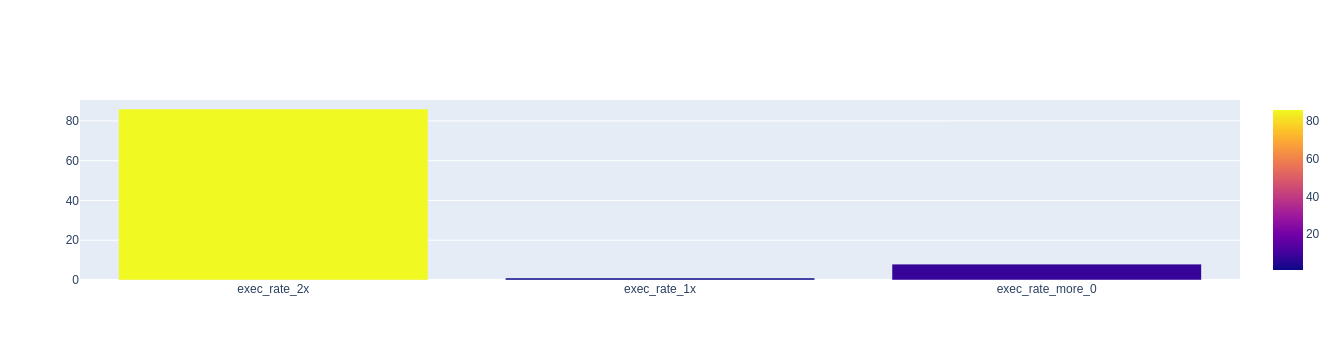

In [83]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['exec_rate_2x', 'exec_rate_1x', 'exec_rate_more_0'], y=lst_exec,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Execution time difference frozen and disabled')
fig.show()

In [84]:
df_filter=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time'])>=2]

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[956770:956770:0329/073602.465537:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


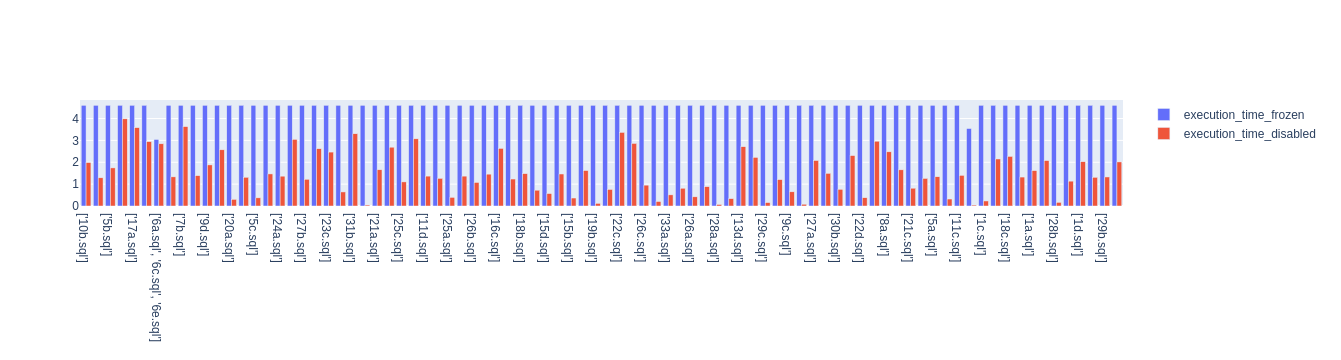

In [87]:
fig = go.Figure()
fig.add_trace(go.Bar(name='execution_time_frozen',x=df_filter['query_name'], y=abs(np.log(df_filter['lst_min_exec_with_aqo']+0.01))))
fig.add_trace(go.Bar(name='execution_time_disabled', x=df_filter['query_name'], y=abs(np.log(execution_without))))
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time and execution time difference in frozen and disabled modes')
fig.show()

## query with cardinality error

In [88]:
frozen_df_query_stat_copy=frozen_df_query_stat.copy()

In [89]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name'],
      dtype='object')

In [90]:
frozen_df_query_stat_copy['diff_card_time']=frozen_df_query_stat_copy['cardinality_error_without_aqo_split_last_value']-frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']

In [91]:
frozen_df_query_stat_copy['rate_card_time']=frozen_df_query_stat_copy['cardinality_error_without_aqo_split_last_value']/frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']

In [92]:
card_rate_2x=frozen_df_query_stat_copy[frozen_df_query_stat_copy['rate_card_time']>=2]

In [93]:
card_rate_1x=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<2) & (frozen_df_query_stat_copy['rate_card_time']>=1)]

In [94]:
card_rate_more_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<1) & (frozen_df_query_stat_copy['rate_card_time']>=0)]

In [95]:
card_rate_less_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<0)]

In [96]:
lst_card=[len(card_rate_2x), len(card_rate_1x), len(card_rate_more_0)]

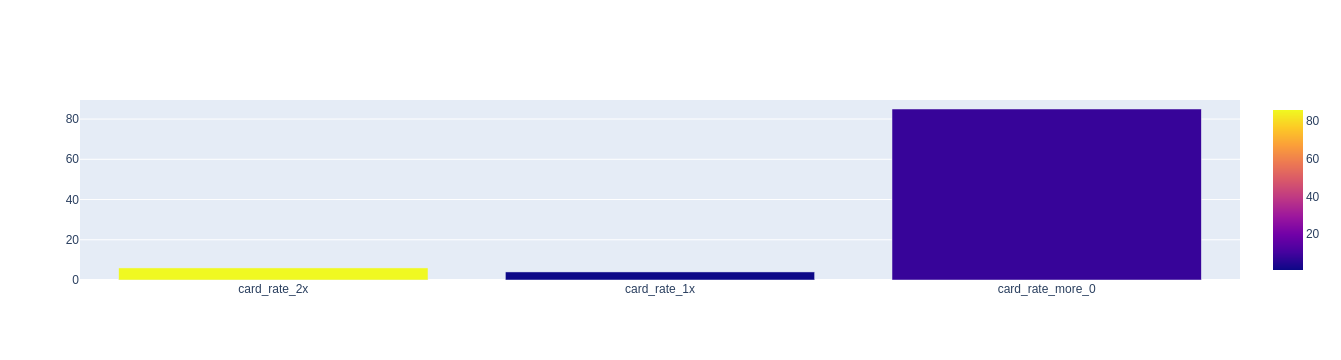

In [97]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['card_rate_2x', 'card_rate_1x', 'card_rate_more_0'], y=lst_card,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [98]:
card_less0_1=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']<=0.15) & (frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']>0)]
card_eq0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']==0)]
card_more0_1=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']>0.15) | (frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']<0)]

In [99]:
frozen_df_query_stat_copy

queryid                cardinality_error_without_aqo_split  \
0     988535410010893112                               [1.1740974144188687]   
1   -6651533820180303979                               [0.7143779554642938]   
2   -3414057395363075461                               [0.9535934648818055]   
3    3350265702090035455                               [3.3363183637430436]   
4    -917204397272063480                               [3.2684367899399627]   
..                   ...                                                ...   
90  -6885312641126422993                                [2.435159900985331]   
91  -1889760809355916724                                [3.422698326281815]   
92  -6571914703387389993                               [0.8192030121145609]   
93   -460740518707800565                               [0.9069711439578045]   
94  -1950505845315524548  [0.9797096177822553, 0.43957725078436244, 1.06...   

                     cardinality_error_with_aqo_split  \
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3   [0.0027783966906946844, 0.002778356698592314, ...   
4   [0.07946027465286959, 0.07617004131003072, 0.0...   
..                                                ...   
90  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
91  [2.3170095303294103, 1.7735356059843947, 1.578...   
92  [0.0036089565574195276, 0.0036089565574195276,...   
93  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
94  [0.011538125913381528, 0.025015150933378454, 0...   

           planning_time_without_aqo_split  \
0                            [0.015594016]   
1                            [0.031032528]   
2                            [0.008931802]   
3                            [0.029298975]   
4                            [0.020102643]   
..                                     ...   
90                           [0.008036279]   
91                           [0.230780345]   
92                           [0.327569353]   
93                           [0.071101805]   
94  [0.007921086, 0.013954692, 0.00773228]   

                         planning_time_with_aqo_split  \
0   [0.028194271, 0.028352469, 0.026671981, 0.0272...   
1   [0.032363881, 0.038153207, 0.035983498, 0.0328...   
2   [0.014672508, 0.016144518, 0.017432597, 0.0165...   
3   [0.045948472, 0.061029942, 0.049650957, 0.0546...   
4   [0.029668493, 0.058551171, 0.029595127, 0.0303...   
..                                                ...   
90  [0.013026643, 0.013024404, 0.013092918, 0.0133...   
91  [2.812807605, 2.88661867, 2.890404912, 2.87908...   
92  [5.206520992, 5.189403478, 5.458860355, 5.5828...   
93  [0.122834183, 0.124250366, 0.110406894, 0.1139...   
94  [0.019904007, 0.013325445, 0.015236774, 0.0152...   

           execution_time_without_aqo_split  \
0                             [0.137276899]   
1                             [3.631126704]   
2                              [0.17511529]   
3                             [53.85370501]   
4                            [35.944772112]   
..                                      ...   
90                            [0.111605584]   
91                            [2.974395668]   
92                            [0.028497469]   
93                            [0.749720758]   
94  [0.206537737, 0.126354247, 0.210021306]   

                        execution_time_with_aqo_split  executions_with_aqo  \
0   [0.114912928, 0.104817202, 0.100696333, 0.1036...                   24   
1   [0.226364218, 0.187767918, 0.188764619, 0.1791...                   24   
2   [0.171582227, 0.172788406, 0.173456698, 0.1785...                   24   
3   [11.031478584, 10.565212299, 10.320725787, 10....                   24   
4   [14.256029774, 13.434793004, 13.498554946, 13....                   24   
..                                                ...                  ...   
90  [0.104416071, 0.100867644, 0.1

In [100]:
lst_card=[len(card_less0_1),len(card_eq0),len(card_more0_1)]

In [101]:
lst_card

[21, 0, 74]

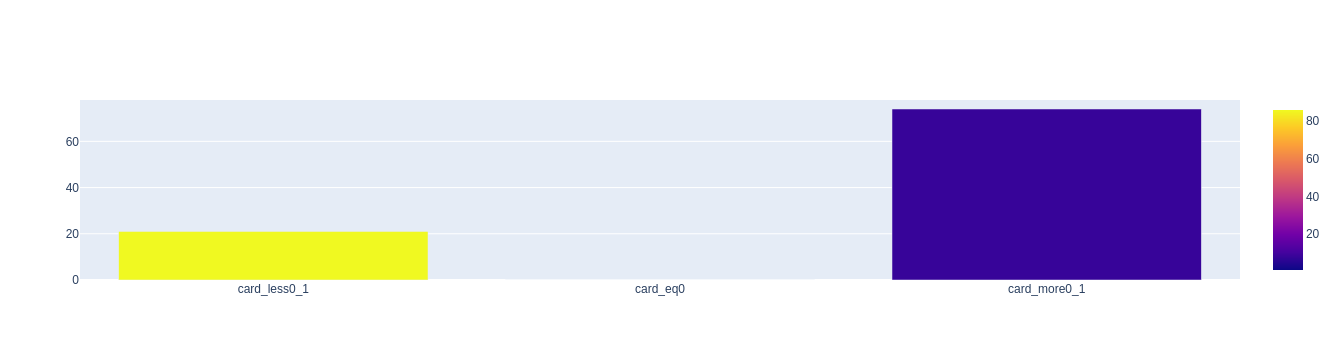

In [102]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['card_less0_1', 'card_eq0', 'card_more0_1'], y=lst_card,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [103]:
df_filter=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time'])>=2]

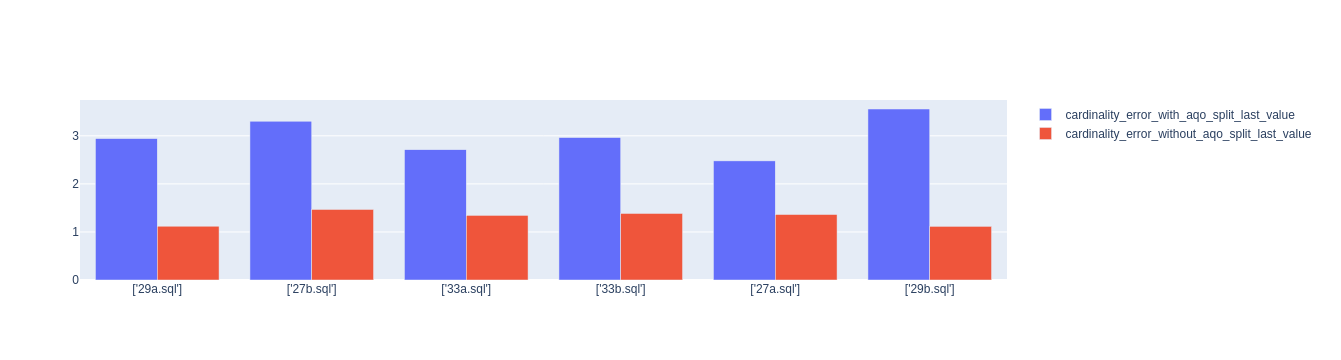

In [104]:
fig = go.Figure()
fig.add_trace(go.Bar(name='cardinality_error_with_aqo_split_last_value',x=df_filter['query_name'], y=abs(np.log(df_filter['cardinality_error_with_aqo_split_last_value']))))
fig.add_trace(go.Bar(name='cardinality_error_without_aqo_split_last_value', x=df_filter['query_name'], y=abs(np.log(df_filter['cardinality_error_without_aqo_split_last_value']))))
fig.show()

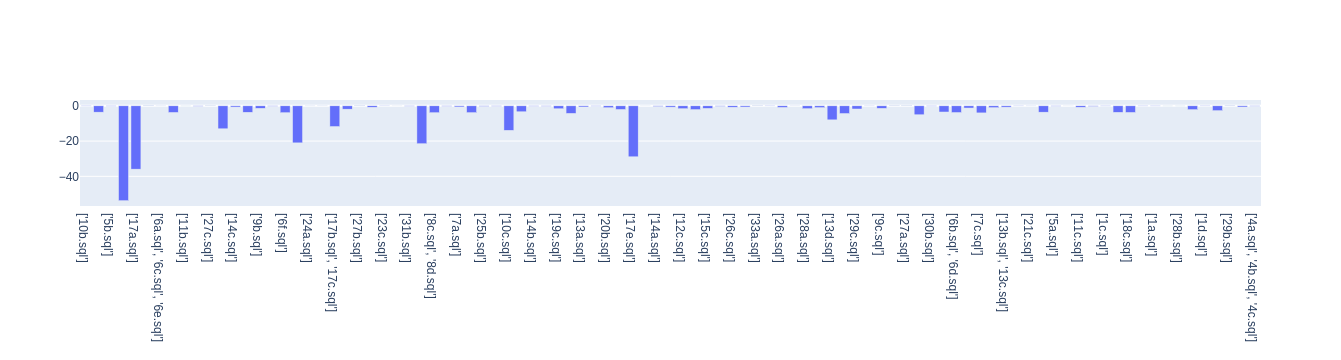

In [105]:
fig = go.Figure()
fig.add_trace(go.Bar(name='cardinality_error',x=frozen_df_query_stat_copy['query_name'], y=frozen_df_query_stat_copy['diff_card_time']))
fig.show()

In [112]:
frozen_df_query_stat_copy['diff_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]-frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [113]:
frozen_df_query_stat_copy[frozen_df_query_stat_copy['diff_exec_time']<0].count()

queryid                                           8
cardinality_error_without_aqo_split               8
cardinality_error_with_aqo_split                  8
planning_time_without_aqo_split                   8
planning_time_with_aqo_split                      8
execution_time_without_aqo_split                  8
execution_time_with_aqo_split                     8
executions_with_aqo                               8
executions_without_aqo                            8
min_iter_card_with                                8
lst_min_val_with_aqo                              8
min_iter_card_without                             8
lst_min_val_without_aqo                           8
min_iter_exec_with                                8
lst_min_exec_with_aqo                             8
cardinality_error_without_aqo_split_last_value    8
cardinality_error_with_aqo_split_last_value       8
query_name                                        8
diff_card_time                                    8
rate_card_ti

In [114]:
frozen_df_query_stat_copy[frozen_df_query_stat_copy['diff_exec_time']>=0].count()

queryid                                           87
cardinality_error_without_aqo_split               87
cardinality_error_with_aqo_split                  87
planning_time_without_aqo_split                   87
planning_time_with_aqo_split                      87
execution_time_without_aqo_split                  87
execution_time_with_aqo_split                     87
executions_with_aqo                               87
executions_without_aqo                            87
min_iter_card_with                                87
lst_min_val_with_aqo                              87
min_iter_card_without                             87
lst_min_val_without_aqo                           87
min_iter_exec_with                                87
lst_min_exec_with_aqo                             87
cardinality_error_without_aqo_split_last_value    87
cardinality_error_with_aqo_split_last_value       87
query_name                                        87
diff_card_time                                